# Merge and clean the phenotype and .fam files

In this notebook we are going to:
* Update the phenotype file so it only includes the phenotypes in a numerical way (not the string colum with affected and unaffected) --> **updated_phenotypes1.txt**
* Merge this pheno file with the fam file --> prefix: **final_IBP1**
* Eliminate the missing phenotype samples --> output: **final_IBP2** (no missing in pheno file; stays the same)
* Eliminate the duplicate phenotype samples --> output: **updated_phenotypes2.txt** (no duplicates in fam file; stays the same)
* Prune --> output: **final_IBP**

### In order to use this notebook we need:
* Original phenotype file --> **Phenotypes_IBP.txt**
* PLINK format files --> prefix: **IBD_GSA_imp_updated**

### The output of this notebook is:
* **final_phenotypes.txt**
* **final_IBP.bim**
* **final_IBP.bed**
* **final_IBP.fam**

In [1]:
plink --version

PLINK v1.90b6.26 64-bit (2 Apr 2022)


In [2]:
pwd
cd /staging/leuven/stg_00092/IBP_PRSproject

/lustre1/project/stg_00092/IBP_PRSproject/jupyter_notebooks


In [3]:
#head the .fam file we need to merge the phenotype data with
head IBD_GSA_imp_updated.fam

9263 9263 0 0 0 -9
9535 9535 0 0 0 -9
5924 5924 0 0 0 -9
2762 2762 0 0 0 -9
9323 9323 0 0 0 -9
7670 7670 0 0 0 -9
1885 1885 0 0 0 -9
8711 8711 0 0 0 -9
10127 10127 0 0 0 -9
2706 2706 0 0 0 -9


In [4]:
#head the phenotype file
head Phenotypes_IBP.txt

IID	Phenotype	IBDvsCON
9263	Unaffected	1
9535	Affected	2
5924	Affected	2
2762	Affected	2
9323	Unaffected	1
7670	Affected	2
1885	Affected	2
8711	Affected	2
10127	Unaffected	1


We need to maje the phenotype file have FID, IID and phenotype

In [5]:
awk '{print $1, $1, $3}' Phenotypes_IBP.txt > updated_phenotypes1.txt
head updated_phenotypes1.txt

IID IID IBDvsCON
9263 9263 1
9535 9535 2
5924 5924 2
2762 2762 2
9323 9323 1
7670 7670 2
1885 1885 2
8711 8711 2
10127 10127 1


In [ ]:
# Merge the .fam file and the phenotypes with the plink command
plink --bfile IBD_GSA_imp_updated --pheno updated_phenotypes1.txt --allow-no-sex --make-bed --out final_IBP1

PLINK v1.90b6.26 64-bit (2 Apr 2022)           www.cog-genomics.org/plink/1.9/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to final_IBP1.log.
Options in effect:
  --allow-no-sex
  --bfile IBD_GSA_imp_updated
  --make-bed
  --out final_IBP1
  --pheno updated_phenotypes1.txt

193099 MB RAM detected; reserving 96549 MB for main workspace.
53723589 variants loaded from .bim file.
3888 people (0 males, 0 females, 3888 ambiguous) loaded from .fam.
Ambiguous sex IDs written to final_IBP1.nosex .
3864 phenotype values present after --pheno.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 3888 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is exactly 1.
53723589 variants and 3888 people pa

## 1. Removing the samples with missing phenotype
We see that some of the individuals did not have a phenotype from the phenotype file. We will have to remove these individuals.

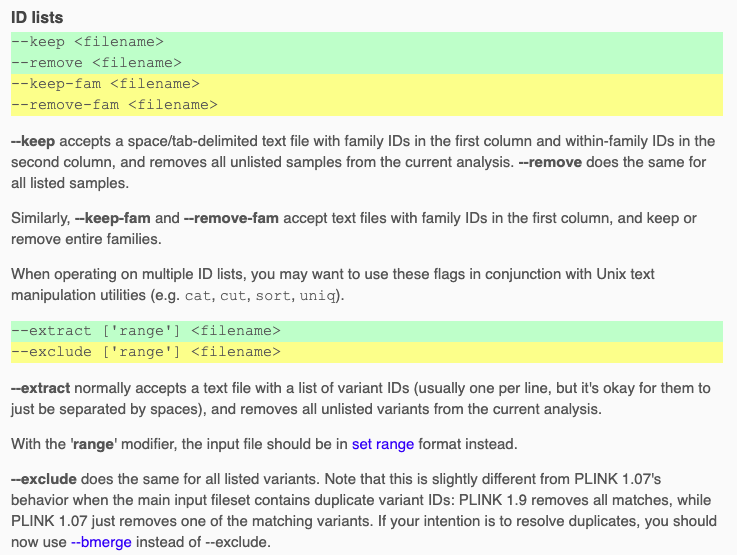

In [ ]:
#make sure the phenotypes were corrected
head final_IBP1.fam

### Remove missing from the fam

In [ ]:
#make a list of the individuals with missing phenotypes
awk '{ if ($6 == -9) print $1}' final_IBP1.fam > missing_phenotypes.txt
cat missing_phenotypes.txt

In [ ]:
#we expect 24 individuals (3888-3864), we also caught the 8069 duplicate!
wc -l  missing_phenotypes.txt

In [ ]:
#remove from the fam file the missing phenotypes
plink --bfile final_IBP1 --remove-fam missing_phenotypes.txt --allow-no-sex --make-bed --out final_IBP2

### Remove missing from the phenotype file

In [ ]:
awk '{if ($2 == -9) print $1}' updated_phenotypes1.txt

## 2. Removing the duplicated samples

### Remove duplicates from the fam file

In [ ]:
sort -n final_IBP2.fam | wc -l
sort -n final_IBP2.fam | uniq | wc -l

### Remove duplicates from the phenotype file

In [ ]:
sort -n updated_phenotypes1.txt | uniq | wc -l
sort -n updated_phenotypes1.txt | wc -l

sort -n updated_phenotypes.txt | uniq -d | awk {'print $1'}

awk '{ if ($1 == 8069) print}' updated_phenotypes1.txt

In [ ]:
awk '!x[$0]++' updated_phenotypes1.txt > updated_phenotypes2.txt
sort -n updated_phenotypes2.txt | uniq | wc -l

# Prune

We can also prune the SNPs. However, the inversion.txt is from the Marees tutorial, maybe there are more we need to consider.

In [ ]:
plink --bfile final_IBP2 --exclude inversion.txt --range --indep-pairwise 50 5 0.2 --out indepSNP


In [ ]:
#we expect 29070215 variants, 53380400 - 24310185 = 29070215
wc -l indepSNP.prune.in 

In [ ]:
wc -l final_IBP2.fam

In [ ]:
plink --bfile final_IBP2 --extract indepSNP.prune.in --allow-no-sex --make-bed --out final_IBP

In [ ]:
#doube check the amount of variants got removed and individuals
wc -l final_IBP.bim
wc -l final_IBP.fam

In [ ]:
#now we can remove the intermediate final_IBP files generated
rm missing_phenotypes.txt
rm -R final_IBP1.*
rm -R final_IBP2.*

In [ ]:
cp -u updated_phenotypes2.txt final_phenotypes.txt

In [ ]:
rm -R updated_phenotypes1.txt
rm -R updated_phenotypes2.txt